# CSC6203 - Intelligent Multimedia Analysis - Problem Code
Christian Willig 

# Load packages

In [46]:
import os
import torch
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gdown

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setting device

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Variables

In [86]:
BATCH_SIZE = 128
# Set number of epochs
NUM_EPOCHS = 15

LEARNING_RATE = 0.001

annotations_file = 'data\\UrbanSound8K\\metadata\\UrbanSound8K.csv'
audio_dir = 'data\\UrbanSound8K\\audio'

# Loading and exploring dataset

## Dataset Loading

Dataset download from Google Drive

In [115]:
# UrbanSound8K: https://drive.google.com/file/d/1YhDutwePttKnnr0UPSJb0u6GdMt3wVU9/view?usp=sharing

!gdown "1YhDutwePttKnnr0UPSJb0u6GdMt3wVU9&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1YhDutwePttKnnr0UPSJb0u6GdMt3wVU9&confirm=t
To: c:\Users\WIL106452\Documents\Learning\Master DS-AI\CSC6203 - Intelligence Multimedia Analysis\Assessments\Assessment 3\UrbanSound8K.tar.gz

  0%|          | 0.00/6.02G [00:00<?, ?B/s]
  0%|          | 524k/6.02G [00:00<1:21:05, 1.24MB/s]
  0%|          | 1.57M/6.02G [00:00<31:59, 3.14MB/s] 
  0%|          | 3.15M/6.02G [00:00<17:29, 5.74MB/s]
  0%|          | 4.72M/6.02G [00:00<13:01, 7.71MB/s]
  0%|          | 6.29M/6.02G [00:00<11:24, 8.79MB/s]
  0%|          | 7.86M/6.02G [00:01<10:16, 9.76MB/s]
  0%|          | 9.44M/6.02G [00:01<09:37, 10.4MB/s]
  0%|          | 11.0M/6.02G [00:01<09:33, 10.5MB/s]
  0%|          | 12.6M/6.02G [00:01<09:35, 10.4MB/s]
  0%|          | 14.2M/6.02G [00:01<09:00, 11.1MB/s]
  0%|          | 15.7M/6.02G [00:01<08:46, 11.4MB/s]
  0%|          | 17.3M/6.02G [00:01<08:37, 11.6MB/s]
  0%|          | 18.9M/6.02G [00:02<20:28, 4.89MB/s]
  0%|          | 20.4M/6.

Untar dataset

In [142]:
import os
import tarfile

# Define the path to downloaded file and the output directory
tar_file = 'UrbanSound8K.tar.gz'
output_dir = 'data'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Open the tar file
with tarfile.open(tar_file, 'r:gz') as tar:
    # Extract all contents to the output directory
    tar.extractall(path=output_dir)

print(f'Contents of {tar_file} have been extracted to {output_dir}')

Contents of UrbanSound8K.tar.gz have been extracted to data


## Dataset exploration

### Annotation file

In [4]:
# Load dataset
annotations = pd.read_csv(annotations_file)

# Extending annotations with the relative path to each file. This will be useful later in the model training.
annotations['relative_path'] = '/fold' + annotations['fold'].astype(str) + '/' + annotations['slice_file_name'].astype(str)

# Explore the Dataset
print("Top 5 rows Overview:")
display(annotations.head())

Top 5 rows Overview:


,slice_file_name,fsID,start,end,salience,fold,classID,class,relative_path
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,/fold5/100032-3-0-0.wav
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,/fold5/100263-2-0-117.wav
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,/fold5/100263-2-0-121.wav
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,/fold5/100263-2-0-126.wav
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,/fold5/100263-2-0-137.wav


Column descriptions*:

* slice_file_name: The name of the audio file.
* fsID: The Freesound ID of the recording from which this excerpt (slice) is taken.
* start: The start time of the slice in the original Freesound recording.
* end: The end time of slice in the original Freesound recording.
* salience: A (subjective) salience rating of the sound. 1 = foreground, 2 = background.
* fold: The fold number (1-10) to which this file has been allocated.
* classID: A numeric identifier of the sound class:

    0 = air_conditioner     
    1 = car_horn    
    2 = children_playing    
    3 = dog_bark    
    4 = drilling    
    5 = engine_idling   
    6 = gun_shot    
    7 = jackhammer  
    8 = siren   
    9 = street_music    

* class: The class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, 
siren, street_music.

*Information taken from https://urbansounddataset.weebly.com/urbansound8k.html

### Class distributions

As we can see in the chart below, the distribution of classes is pretty even among the classes except for car_horn and gun_shot which have 50% less representation in the dataset. This might be bad news for those classes as they don't have enough representation for the model to learn from. We are facing a slightly unbalanced dataset.

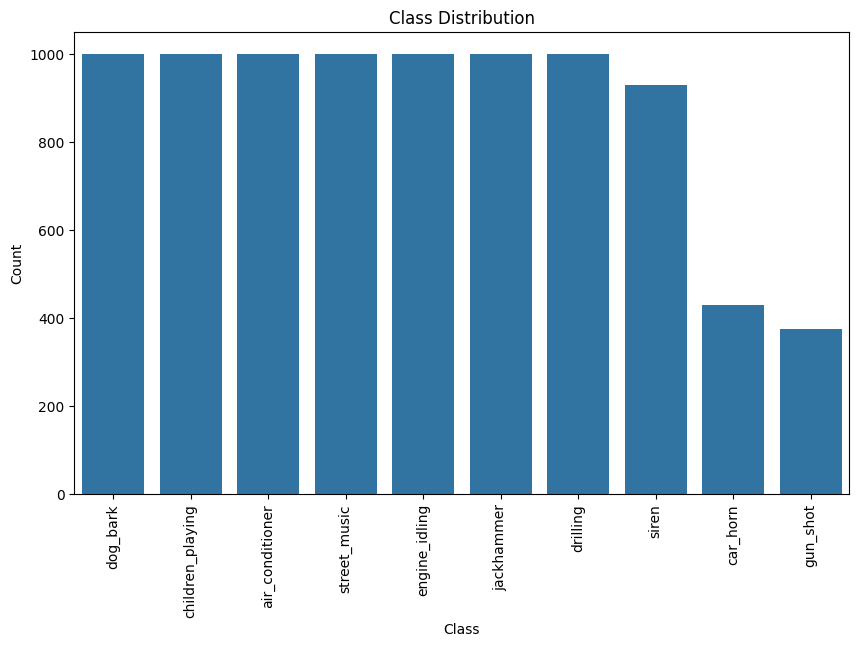

In [127]:
# Let's analyze class distribution
class_distribution = annotations['class'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

### Channels

Adding channel and duration into the annotations file for easier analysis.

In [128]:
import struct
import numpy as np

def get_channel(file_path):
    with open(file_path,'rb') as audio_file:
        # Getting the audio file parameters
        # Read the header to get audio file information
        
        header = audio_file.read(44) # In WAV files, first 44 bytes are reserved for the header
        #print(f"The header is {header}")
        
        if header[:4] != b'RIFF' or header[8:12] != b'WAVE' or header[12:16] != b'fmt ':
            raise ValueError("Invalid WAV file")
            
        channels = struct.unpack('<H', header[22:24])[0]
    
    return channels

durations = []
channel_arr = []
for idx, row in annotations.iterrows():
    audio_path = os.path.join(audio_dir, "fold"+str(row['fold']), row['slice_file_name'])
    channels = get_channel('.\\' + str(audio_path))
    audio, sr = librosa.load(audio_path, sr=None)
    durations.append(librosa.get_duration(y=audio, sr=sr))
    channel_arr.append(channels)

annotations['duration'] = durations
annotations['channel'] = channel_arr

Channels are an important aspects of sound. As we can see in the chart below that majority of the sound files have 2 channels and about 1000 files have only 1 channel.

<Axes: xlabel='channel'>

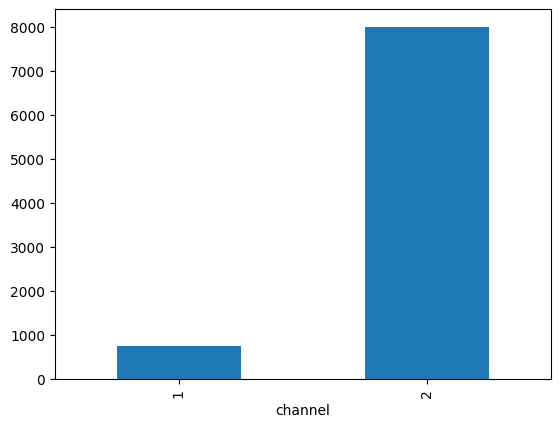

In [129]:
import pandas as pd
import matplotlib.pyplot as plt

#calculate sum of points for each team
df_groups = annotations.groupby('channel')['slice_file_name'].count()

#create bar plot by group
df_groups.plot(kind='bar')

### Duration

Below we calculate the statistics and plot the distribution of the duration. We can see that majority of the sound files have a duration of 4 seconds, and there are a few ones that go between 0.5 and 2 seconds.

Audio Duration Statistics:
 count    8732.000000
mean        3.607522
std         0.974394
min         0.050000
25%         4.000000
50%         4.000000
75%         4.000000
max         4.036647
Name: duration, dtype: float64


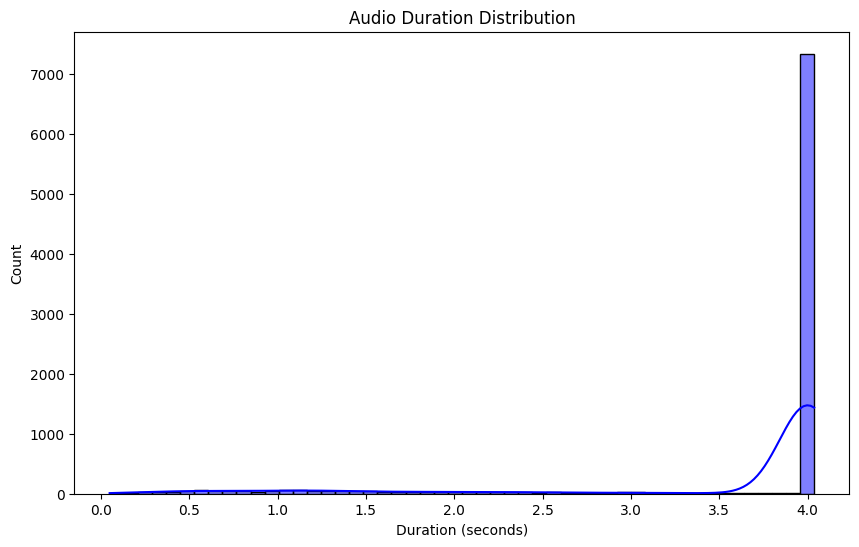

In [130]:
# Let's analyse now audio duration

print("Audio Duration Statistics:\n", annotations['duration'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(annotations['duration'], bins=50, kde=True, color='blue')
plt.title('Audio Duration Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.show()

### Spectograms

In audio classification, similar to image classification, we provide the model with visual representations of sound. This is achieved through a spectrogram, which illustrates the sound’s features by showing how its frequency content varies over time. Brighter regions on the spectrogram indicate higher energy or amplitude. This method enables us to see not only the general pitch and loudness of the sound but also finer details like harmonics.

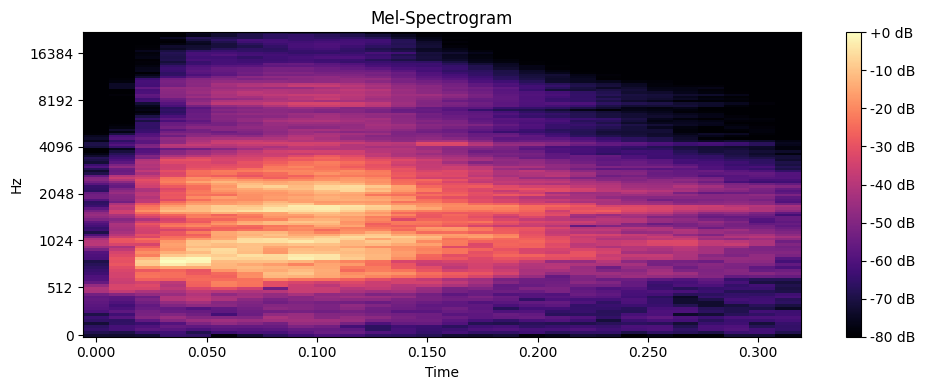

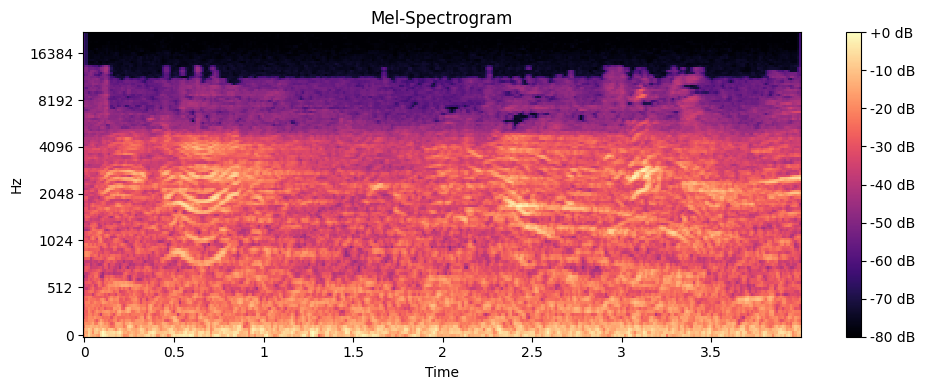

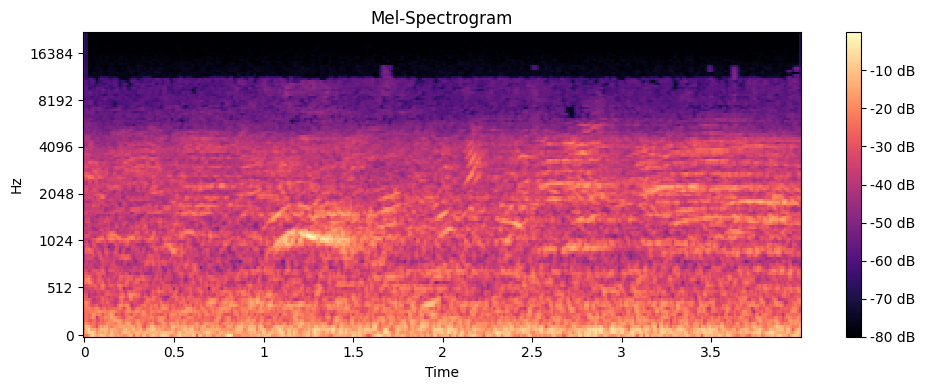

Class Distribution:
 class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64
Audio Duration Statistics:
 count    8732.000000
mean        3.607522
std         0.974394
min         0.050000
25%         4.000000
50%         4.000000
75%         4.000000
max         4.036647
Name: duration, dtype: float64


In [12]:
# helper function to plot spectograms
def plot_mel_spectrogram(audio_path):
    audio, sr = librosa.load(audio_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Spectrogram')
    plt.tight_layout()
    plt.show()

# Plot mel-spectrograms for 3 samples
for idx in range(3):
    audio_path = os.path.join(audio_dir, "fold"+str(annotations.iloc[idx]['fold']), annotations.iloc[idx]['slice_file_name'])
    plot_mel_spectrogram(audio_path)


# Dataset Preparation

### Dataset classes

To feed the data to out pytorch models we’ll implement two objects: 

- *AudioUtil* to perform all necessary transformations and 
- a custom class for our dataset using *torch.utils.data.Dataset* to manage file loading.

The UrbanSound8K dataset is divided into 10 folders and the authors recommend to use the folds for doing a 10-fold cross-validation to report metrics and evaluate the performance of our model. However, to keep things simple for this assessment and focus on modeling audio classification with deep learning algorithms example rather than to obtain the best metrics, we will ignore the folds and treat all the samples simply as one large dataset.

In [143]:
import random
import torch
import torchaudio
from torchaudio import transforms

class AudioUtil():
    
    def open_audio(audio_path):
        signal, sample_rate = torchaudio.load(audio_path)
        return (signal, sample_rate)
    
    def rechannel(aud, new_channel):
        sig, sr = aud

        if (sig.shape[0] == new_channel):
          # Nothing to do
          return aud

        if (new_channel == 1):
          # Convert from stereo to mono by selecting only the first channel
          resig = sig[:1, :]
        else:
          # Convert from mono to stereo by duplicating the first channel
          resig = torch.cat([sig, sig])

        return ((resig, sr))
    
    def resample(aud, new_sample_rate):
        
        signal, sample_rate = aud
        n_channels = signal.shape[0]
        if (sample_rate != new_sample_rate):
            resig = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(signal[:1,:])
            if (n_channels > 1):
                retwo = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(signal[1:,:])
                resig = torch.cat([resig,retwo])
            return ((resig, new_sample_rate))
        else:
            return aud
        
    def pad_trunc(aud, max_ms):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr // 1000 * max_ms

        if sig_len > max_len:
            # Truncate the signal to the given length
            sig = sig[:, :max_len]
        elif sig_len < max_len:
            # Calculate the length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            sig = torch.cat((pad_begin, sig, pad_end), 1)

        return (sig, sr)
    
    def time_shift(aud, shift_limit):
        sig,sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)
    
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig,sr = aud
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)
    
    def LFCC(aud, sr = 16000, n_lfcc = 64, n_fft=1024, hop_len=None):
        sig,sr = aud
        top_db = 80
        spec = transforms.LFCC(sr, speckwargs={"n_fft": n_fft, "hop_length": hop_len, "center": False}, n_lfcc = n_lfcc)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)
    
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec


In [6]:
from torch.utils.data import Dataset

class SoundDS(Dataset):
    def __init__(self, df, data_path):
        self.df = df
        self.data_path = str(data_path)
        self.classes = set(self.df['class'])
        self.duration = 4000
        self.sr = 44100
        self.channel = 2
        self.shift_pct = 0.4
            
   # ----------------------------
   # Number of items in dataset
   # ----------------------------
    def __len__(self):
        return len(self.df)    
      
   # ----------------------------
   # Get i'th item in dataset
   # ----------------------------
    def __getitem__(self, idx):
        # Absolute file path of the audio file - concatenate the audio directory with
        # the relative path
        audio_file = self.data_path + self.df.loc[idx, 'relative_path']
        # Get the Class ID
        class_id = self.df.loc[idx, 'classID']

        aud = AudioUtil.open_audio(audio_file)
        # Some sounds have a higher sample rate, or fewer channels compared to the
        # majority. So make all sounds have the same number of channels and same 
        # sample rate. Unless the sample rate is the same, the pad_trunc will still
        # result in arrays of different lengths, even though the sound duration is
        # the same.
        reaud = AudioUtil.resample(aud, self.sr)
        rechan = AudioUtil.rechannel(reaud, self.channel)

        dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
        shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
        sgram = AudioUtil.LFCC(shift_aud, n_lfcc=64, n_fft=1024, hop_len=None)
        # sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
        aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

        return aug_sgram, class_id

### Data split
We split the dataset into training (70%), validation (20%) and testing (10%).

In [7]:
# Split in to train val and test subsets
from torch.utils.data import random_split

dataset = SoundDS(annotations, audio_dir)

train_len = int(0.7 * len(dataset))
val_len = int(0.2 * len(dataset))
test_len = len(dataset) - train_len - val_len

train_ds, val_ds, test_ds = random_split(dataset, [train_len, val_len, test_len], )

len(train_ds), len(val_ds), len(test_ds)

(6112, 1746, 874)

In [17]:
dataset.classes

{'air_conditioner',
 'car_horn',
 'children_playing',
 'dog_bark',
 'drilling',
 'engine_idling',
 'gun_shot',
 'jackhammer',
 'siren',
 'street_music'}

### Dataloaders
The dataloaders are special stuctures in pytorch that facilitates the training process by providing an iterable over the dataset. We will use a batch size of 32, as defined in the variable section.

In [10]:
# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=BATCH_SIZE, # specify many samples per batch
                                       #num_workers=2, # specify how many subprocesses to use for data loading
                                       shuffle=True)
                                       #pin_memory=True)

val_dl = torch.utils.data.DataLoader(val_ds, 
                                     batch_size=BATCH_SIZE, # specify many samples per batch
                                     #num_workers=2, # specify how many subprocesses to use for data loading
                                     shuffle=False)
                                    #  pin_memory=True)

test_dl = torch.utils.data.DataLoader(test_ds, 
                                      batch_size=BATCH_SIZE, 
                                      #num_workers=2, 
                                      shuffle=False)

train_dl, val_dl, test_dl

(<torch.utils.data.dataloader.DataLoader at 0x198b5a10880>,
 <torch.utils.data.dataloader.DataLoader at 0x198b5a130a0>)

# Model design and implementation
Templates and inspiration: 
- https://github.com/bentrevett/pytorch-image-classification/blob/master/README.md
- https://medium.com/@mlg.fcu/using-python-to-classify-sounds-a-deep-learning-approach-ef00278bb6ad
- https://cs231n.github.io/convolutional-networks/
- https://github.com/smitkiri/urban-sound-classification/blob/master/Sound%20classification.ipynb
- https://github.com/IvanLauLinTiong/pytorch_audio/blob/master/urbansounddataset.py

In [149]:
# Explore the input shapes
s, l = next(iter(train_dl))
print(s.size()) #(batch_size, channels, time_steps, features)
print(s.size()[2])
print(l)
len(train_ds.dataset.classes)

torch.Size([128, 2, 64, 342])
64
tensor([5, 3, 7, 3, 4, 9, 6, 0, 7, 0, 4, 7, 3, 2, 7, 7, 3, 7, 3, 5, 3, 7, 4, 5,
        0, 8, 4, 6, 4, 0, 8, 4, 5, 0, 3, 3, 0, 9, 7, 9, 3, 9, 0, 3, 7, 5, 5, 9,
        5, 4, 8, 3, 7, 6, 4, 3, 9, 7, 2, 7, 0, 5, 1, 0, 8, 3, 6, 7, 2, 0, 9, 0,
        7, 0, 7, 4, 9, 9, 5, 0, 9, 2, 8, 3, 4, 0, 1, 4, 4, 0, 3, 4, 8, 4, 4, 0,
        9, 0, 0, 8, 1, 9, 3, 4, 8, 2, 0, 9, 1, 8, 3, 7, 9, 0, 5, 7, 5, 2, 0, 4,
        0, 4, 0, 4, 6, 8, 2, 5])


10

### CNN
This network consists of three convolutional layers followed by max pooling layers, and two fully connected layers for final classification. The first convolution layer (self.conv1) has 16 output channels, the second (self.conv2) has 32, and the third (self.conv3) has 64, all with a kernel size of 3x3, stride of 1, and padding of 1. Each convolution layer is followed by a ReLU activation and a max pooling layer (self.pool) with a kernel size of 2x2 and stride of 2. The output size after the CNN layers is calculated for the first fully connected layer (self.fc1), which has 128 output features and uses ReLU activation. The second fully connected layer (self.fc2) maps to the number of output classes (num_classes). The forward method processes the input through the convolutional layers, flattens the output, and passes it through the fully connected layers to produce the final class predictions.

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class CNN_Model(nn.Module):
    def __init__(self, num_classes):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Calculate the output size after the CNN layers
        self.fc1_input_size = 64 * (64 // 8) * (342 // 8)
        self.fc1 = nn.Linear(self.fc1_input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)  # Adjust based on input size
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

torch.manual_seed(42)
model_0 = CNN_Model(num_classes=len(train_ds.dataset.classes)).to(device)

model_0

CNN_Model(
  (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=21504, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### CRNN
This network is designed for tasks requiring both spatial and temporal feature extraction, such as audio classification. The architecture combines convolutional layers for spatial feature extraction with a Gated Recurrent Unit (GRU) for temporal sequence modeling. It includes two convolutional layers: the first with 16 output channels and the second with 32, both followed by ReLU activation and max pooling to reduce spatial dimensions. The GRU layer is bidirectional with a specified hidden size and number of layers, capturing temporal dependencies. The fully connected layer maps the GRU output to the desired number of classes. In the forward pass, the input is processed through the convolutional layers, flattened, and passed through the GRU. The output from the last time step of the GRU is then passed through the fully connected layer to produce the final class predictions. This CRNN architecture effectively combines CNNs for spatial feature extraction and GRUs for temporal sequence modeling, making it well-suited for tasks like audio classification.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CRNN_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CRNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1)  # Adjusted for 2 input channels
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.gru = nn.GRU(32 * (input_size // 4), hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), x.size(2), -1)  # Flatten the feature maps
        h0 = torch.zeros(self.gru.num_layers * 2, x.size(0), self.gru.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

torch.manual_seed(42)
model_1 = CRNN_Model(input_size=342,
                     hidden_size = 256,
                     num_layers = 2,
                     num_classes=len(train_ds.dataset.classes)).to(device)
model_1

CRNN_Model(
  (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gru): GRU(2720, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

## CNN-LSTM
This network combines Convolutional Neural Networks (CNNs) and Long Short-Term Memory (LSTM) networks for tasks requiring both spatial and temporal feature extraction, such as audio classification. The model includes three convolutional layers with 16, 32, and 64 output channels, respectively, each followed by ReLU activation and max pooling to reduce spatial dimensions. The LSTM layer has an input size based on the CNN output, a hidden size of 128, and 2 layers, with a dropout of 0.2 to prevent overfitting. The forward pass processes the input through the convolutional layers, reshapes it for the LSTM, and passes it through the LSTM with initial hidden and cell states set to zeros. The output from the last time step of the LSTM is then passed through two fully connected layers to produce the final class predictions. This architecture effectively combines CNNs for spatial feature extraction and LSTMs for temporal sequence modeling.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNLSTM(nn.Module):
    def __init__(self, num_classes):
        super(CNNLSTM, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Calculate the output size after the CNN layers
        self.lstm_input_size = 64 * (64 // 8) * (342 // 8)  # Adjust based on pooling layers
        self.hidden_size = 128
        self.num_layers = 2
        
        self.lstm = nn.LSTM(2688, self.hidden_size, self.num_layers, batch_first=True, dropout=0.2)
        self.fc1 = nn.Linear(self.hidden_size, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # CNN layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Reshape for LSTM
        # print(f'Batch size: {x.size()}')
        batch_size, channels, time_steps, features = x.size()
        x = x.permute(0, 2, 1, 3).contiguous()  # (batch_size, time_steps, channels, features)
        x = x.view(batch_size, time_steps, -1)  # (batch_size, time_steps, lstm_input_size)
        # print(f'X permutted size: {x.size()}')
        
        # LSTM layers
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        # print(f'h0: {h0.size()} and c0: {c0.size()}')
        x, _ = self.lstm(x, (h0, c0))
        
        # Fully connected layers
        x = F.relu(self.fc1(x[:, -1, :]))
        x = self.fc2(x)
        return x

torch.manual_seed(42)
model_2 = CNNLSTM(num_classes = len(train_ds.dataset.classes)).to(device)
model_2

CNNLSTM(
  (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(2688, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

# Utility functions

## Train step
The *train_step* function will be used during training of the model, performing one training step on a batch of data. By training step I mean: forward pass, backward pass and optimisation.

In [16]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

## Validation step
The *val_step* is used during the validation of the model. It performs one validation step on a batch of validation data, evaluating the model's performance.

In [17]:
def val_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup val loss and val accuracy values
    val_loss, val_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            val_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            # Calculate and accumulate accuracy
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

## Test step

In [ ]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    return all_preds, all_targets, test_loss, accuracy

## Model Training function
The *train* function will glue the previous two functions above, performing the actual training and performance validation of the model.

In [18]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        val_loss, val_acc = val_step(model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    # 6. Return the filled results at the end of the epochs
    return results

c:\Users\WIL106452\Documents\Learning\Master DS-AI\venv_csc6203_as3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Accuracy calc function

In [19]:
# Calculate accuracy (a classification metric)
def accuracy_function(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

## Plot loss curves
The *plot_loss_curves* function wil help in plotting the train and val scores using matplot library.

In [20]:
import matplotlib.pyplot as plt
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['val_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['val_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

## Save model
Function for saving trained models

In [21]:
from pathlib import Path

def save_model(name, model, path):
    MODEL_PATH = Path(path)
    MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                    exist_ok=True # if models directory already exists, don't error
    )

    # Create model save path
    MODEL_NAME = name
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

    # Save the model state dict
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
            f=MODEL_SAVE_PATH)
    print("Model " + name + " saved")

## Visualise Training Curve

In [22]:
def visualize_training_curve(train_result_dictionary):
    # Define Data
    df = pd.DataFrame(train_result_dictionary)
    x = df.index
    data_1 = df['train_loss']
    data_2 = df['val_loss']
    data_3 = df['train_acc']

    # Create Plot
    fig, ax1 = plt.subplots(figsize=(7, 7))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.plot(x, data_1, color='red', label='training loss')
    ax1.plot(x, data_2, color='blue', label='validation loss')

    # Adding Twin Axes
    ax2 = ax1.twinx()
    ax2.plot(x, data_3, color='green', label='Training Accuracy')

    # Add label
    plt.ylabel('Accuracy')
    lines = ax1.get_lines() + ax2.get_lines()
    ax1.legend(lines, [line.get_label() for line in lines], loc='upper center')

    # Show plot
    plt.show()

## Evaluate model
Evaluates a given model on a given dataset

In [23]:
def evaluate_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn,
               device: torch.device = device):

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

## Confusion Matrix function

In [66]:
def plot_conf_matrix(model, dataloader, test_data, device):
    # 1. Make predictions with trained model
    y_preds = []
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(dataloader, desc="Making predictions"):
            # Send data and targets to target device
            X, y = X.to(device), y.to(device)
            # Do the forward pass
            y_logit = model(X)
            # Turn predictions from logits -> prediction probabilities -> predictions labels
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
            # Put predictions on CPU for evaluation
            y_preds.append(y_pred.cpu())
    # Concatenate list of predictions into a tensor
    y_pred_tensor = torch.cat(y_preds)

    # 2. Setup confusion matrix instance and compare predictions to targets
    confmat = ConfusionMatrix(num_classes=len(train_ds.dataset.classes), task='multiclass')
    confmat_tensor = confmat(preds=y_pred_tensor,
                            target=torch.Tensor(test_data.dataset.df['classID']))

    # 3. Plot the confusion matrix
    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
        class_names=train_ds.dataset.classes, # turn the row and column labels into class names
        figsize=(10, 7)
    );

In [83]:
test_ds.dataset

# Model Training and Evaluation

### Model 0: CNN

In [87]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
# NUM_EPOCHS = 10

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=LEARNING_RATE)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dl,
                        val_dataloader=val_dl,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  7%|▋         | 1/15 [04:02<56:34, 242.47s/it]

Epoch: 1 | train_loss: 1.0319 | train_acc: 0.6343 | val_loss: 1.0633 | val_acc: 0.6309


 13%|█▎        | 2/15 [07:30<48:08, 222.21s/it]

Epoch: 2 | train_loss: 0.8990 | train_acc: 0.6846 | val_loss: 0.9379 | val_acc: 0.6727


 20%|██        | 3/15 [09:48<36:47, 183.93s/it]

Epoch: 3 | train_loss: 0.8627 | train_acc: 0.6952 | val_loss: 0.9539 | val_acc: 0.6644


 27%|██▋       | 4/15 [12:49<33:30, 182.74s/it]

Epoch: 4 | train_loss: 0.7995 | train_acc: 0.7197 | val_loss: 1.0707 | val_acc: 0.6382


 33%|███▎      | 5/15 [14:33<25:43, 154.38s/it]

Epoch: 5 | train_loss: 0.7867 | train_acc: 0.7308 | val_loss: 0.8515 | val_acc: 0.7024


 40%|████      | 6/15 [17:37<24:37, 164.21s/it]

Epoch: 6 | train_loss: 0.7520 | train_acc: 0.7370 | val_loss: 0.8787 | val_acc: 0.7030


 47%|████▋     | 7/15 [19:25<19:26, 145.85s/it]

Epoch: 7 | train_loss: 0.7322 | train_acc: 0.7456 | val_loss: 0.8561 | val_acc: 0.7120


 53%|█████▎    | 8/15 [21:08<15:25, 132.21s/it]

Epoch: 8 | train_loss: 0.6982 | train_acc: 0.7585 | val_loss: 0.8393 | val_acc: 0.7134


 60%|██████    | 9/15 [22:53<12:22, 123.73s/it]

Epoch: 9 | train_loss: 0.6972 | train_acc: 0.7539 | val_loss: 0.8650 | val_acc: 0.7014


 67%|██████▋   | 10/15 [24:38<09:49, 117.94s/it]

Epoch: 10 | train_loss: 0.6777 | train_acc: 0.7606 | val_loss: 0.8468 | val_acc: 0.7117


 73%|███████▎  | 11/15 [26:18<07:29, 112.48s/it]

Epoch: 11 | train_loss: 0.6507 | train_acc: 0.7687 | val_loss: 0.8309 | val_acc: 0.7237


 80%|████████  | 12/15 [28:00<05:27, 109.29s/it]

Epoch: 12 | train_loss: 0.6319 | train_acc: 0.7770 | val_loss: 0.8487 | val_acc: 0.7178


 87%|████████▋ | 13/15 [29:42<03:34, 107.24s/it]

Epoch: 13 | train_loss: 0.6291 | train_acc: 0.7765 | val_loss: 0.8429 | val_acc: 0.7208


 93%|█████████▎| 14/15 [33:03<02:15, 135.51s/it]

Epoch: 14 | train_loss: 0.5997 | train_acc: 0.7839 | val_loss: 0.7493 | val_acc: 0.7552


100%|██████████| 15/15 [36:50<00:00, 147.37s/it]

Epoch: 15 | train_loss: 0.5428 | train_acc: 0.8094 | val_loss: 0.7260 | val_acc: 0.7537
Total training time: 2210.711 seconds


After training model we save it and the results as well

In [88]:
import pandas as pd

save_model(name="model_00_cnn.pth", model=model_0, path="./models")
pd.DataFrame(model_0_results).to_csv("./models/model_0_results.csv")

Saving model to: models\model_00_cnn.pth
Model model_00_cnn.pth saved


### Model 1: RNN

In [89]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
# NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=LEARNING_RATE)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_1_results = train(model=model_1,
                        train_dataloader=train_dl,
                        val_dataloader=val_dl,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  7%|▋         | 1/15 [03:29<48:49, 209.28s/it]

Epoch: 1 | train_loss: 1.0457 | train_acc: 0.6264 | val_loss: 0.9867 | val_acc: 0.6514


 13%|█▎        | 2/15 [05:24<33:22, 154.03s/it]

Epoch: 2 | train_loss: 0.9388 | train_acc: 0.6696 | val_loss: 0.9241 | val_acc: 0.6830


 20%|██        | 3/15 [07:09<26:16, 131.36s/it]

Epoch: 3 | train_loss: 0.9103 | train_acc: 0.6826 | val_loss: 0.9018 | val_acc: 0.6811


 27%|██▋       | 4/15 [08:53<22:10, 120.94s/it]

Epoch: 4 | train_loss: 0.8684 | train_acc: 0.6942 | val_loss: 0.8857 | val_acc: 0.6845


 33%|███▎      | 5/15 [10:39<19:13, 115.39s/it]

Epoch: 5 | train_loss: 0.8531 | train_acc: 0.7080 | val_loss: 0.9638 | val_acc: 0.6548


 40%|████      | 6/15 [12:26<16:53, 112.57s/it]

Epoch: 6 | train_loss: 0.8250 | train_acc: 0.7025 | val_loss: 0.9381 | val_acc: 0.6805


 47%|████▋     | 7/15 [14:13<14:46, 110.84s/it]

Epoch: 7 | train_loss: 0.8147 | train_acc: 0.7088 | val_loss: 0.9022 | val_acc: 0.6910


 53%|█████▎    | 8/15 [15:58<12:42, 108.91s/it]

Epoch: 8 | train_loss: 0.8077 | train_acc: 0.7141 | val_loss: 0.8853 | val_acc: 0.6982


 60%|██████    | 9/15 [17:34<10:28, 104.76s/it]

Epoch: 9 | train_loss: 0.7467 | train_acc: 0.7389 | val_loss: 0.8068 | val_acc: 0.7270


 67%|██████▋   | 10/15 [19:09<08:28, 101.80s/it]

Epoch: 10 | train_loss: 0.7596 | train_acc: 0.7299 | val_loss: 0.8673 | val_acc: 0.6863


 73%|███████▎  | 11/15 [20:44<06:39, 99.82s/it] 

Epoch: 11 | train_loss: 0.7515 | train_acc: 0.7326 | val_loss: 0.8696 | val_acc: 0.6963


 80%|████████  | 12/15 [22:29<05:04, 101.36s/it]

Epoch: 12 | train_loss: 0.7229 | train_acc: 0.7472 | val_loss: 0.7869 | val_acc: 0.7214


 87%|████████▋ | 13/15 [25:04<03:54, 117.40s/it]

Epoch: 13 | train_loss: 0.7593 | train_acc: 0.7291 | val_loss: 0.8805 | val_acc: 0.6934


 93%|█████████▎| 14/15 [27:10<02:00, 120.19s/it]

Epoch: 14 | train_loss: 0.7184 | train_acc: 0.7534 | val_loss: 0.7765 | val_acc: 0.7272


100%|██████████| 15/15 [28:46<00:00, 115.07s/it]

Epoch: 15 | train_loss: 0.6820 | train_acc: 0.7598 | val_loss: 0.8457 | val_acc: 0.7056
Total training time: 1726.098 seconds


In [90]:
import pandas as pd

save_model(name="model_01_rnn.pth", model=model_1, path="./models")
pd.DataFrame(model_1_results).to_csv("./models/model_1_results.csv")

Saving model to: models\model_01_rnn.pth
Model model_01_rnn.pth saved


## Model 2: CNN-LSTM

In [91]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
#NUM_EPOCHS = 10

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=LEARNING_RATE)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_2_results = train(model=model_2,
                        train_dataloader=train_dl,
                        val_dataloader=val_dl,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  7%|▋         | 1/15 [01:36<22:33, 96.69s/it]

Epoch: 1 | train_loss: 1.3530 | train_acc: 0.4974 | val_loss: 1.2808 | val_acc: 0.5187


 13%|█▎        | 2/15 [03:11<20:39, 95.34s/it]

Epoch: 2 | train_loss: 1.2688 | train_acc: 0.5271 | val_loss: 1.2730 | val_acc: 0.5258


 20%|██        | 3/15 [04:44<18:51, 94.30s/it]

Epoch: 3 | train_loss: 1.2480 | train_acc: 0.5330 | val_loss: 1.1943 | val_acc: 0.5529


 27%|██▋       | 4/15 [06:16<17:10, 93.70s/it]

Epoch: 4 | train_loss: 1.2032 | train_acc: 0.5547 | val_loss: 1.1977 | val_acc: 0.5602


 33%|███▎      | 5/15 [07:51<15:38, 93.88s/it]

Epoch: 5 | train_loss: 1.1779 | train_acc: 0.5676 | val_loss: 1.1475 | val_acc: 0.5731


 40%|████      | 6/15 [09:25<14:05, 93.96s/it]

Epoch: 6 | train_loss: 1.1438 | train_acc: 0.5776 | val_loss: 1.1547 | val_acc: 0.5657


 47%|████▋     | 7/15 [11:00<12:34, 94.32s/it]

Epoch: 7 | train_loss: 1.1221 | train_acc: 0.5843 | val_loss: 1.1757 | val_acc: 0.5671


 53%|█████▎    | 8/15 [12:35<11:01, 94.51s/it]

Epoch: 8 | train_loss: 1.1036 | train_acc: 0.6020 | val_loss: 1.1917 | val_acc: 0.5529


 60%|██████    | 9/15 [14:10<09:27, 94.66s/it]

Epoch: 9 | train_loss: 1.0489 | train_acc: 0.6160 | val_loss: 1.0231 | val_acc: 0.6311


 67%|██████▋   | 10/15 [15:44<07:52, 94.40s/it]

Epoch: 10 | train_loss: 1.0318 | train_acc: 0.6303 | val_loss: 1.1086 | val_acc: 0.5951


 73%|███████▎  | 11/15 [17:17<06:16, 94.02s/it]

Epoch: 11 | train_loss: 1.0026 | train_acc: 0.6440 | val_loss: 0.9955 | val_acc: 0.6332


 80%|████████  | 12/15 [18:51<04:42, 94.12s/it]

Epoch: 12 | train_loss: 0.9419 | train_acc: 0.6635 | val_loss: 0.9381 | val_acc: 0.6628


 87%|████████▋ | 13/15 [20:57<03:27, 103.75s/it]

Epoch: 13 | train_loss: 0.9578 | train_acc: 0.6584 | val_loss: 0.9170 | val_acc: 0.6717


 93%|█████████▎| 14/15 [23:21<01:55, 115.97s/it]

Epoch: 14 | train_loss: 0.9234 | train_acc: 0.6742 | val_loss: 0.9214 | val_acc: 0.6741


100%|██████████| 15/15 [25:20<00:00, 101.35s/it]

Epoch: 15 | train_loss: 0.8502 | train_acc: 0.6951 | val_loss: 0.9002 | val_acc: 0.6696
Total training time: 1520.272 seconds


In [92]:
import pandas as pd

save_model(name="model_02_cnn-lstm.pth", model=model_1, path="./models")
pd.DataFrame(model_2_results).to_csv("model_2_results.csv")

Saving model to: models\model_02_cnn-lstm.pth
Model model_02_cnn-lstm.pth saved


## Evaluation

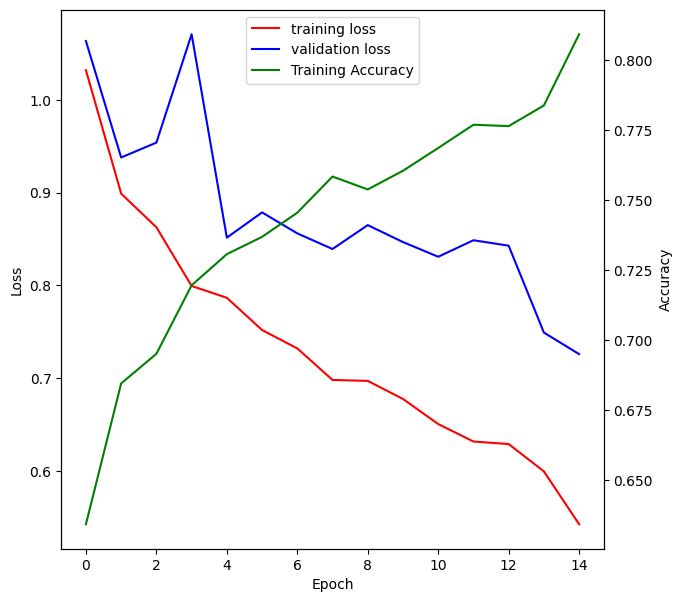

In [97]:
visualize_training_curve(model_0_results)

The chart illustrates the training process of a Convolutional Neural Network (CNN) model over 15 epochs demonstrating the model's learning process, with decreasing training loss and increasing accuracy. The blue line represents the training loss, which decreases steadily from around 1.0 to approximately 0.6, indicating that the model is learning and reducing error over time. The red line shows the validation loss, which also decreases but exhibits some slight fluctuations, suggesting potential overfitting or instability during training. The green line represents training accuracy, which increases consistently from about 0.650 to 0.800, demonstrating the model’s improving ability to correctly classify training data.

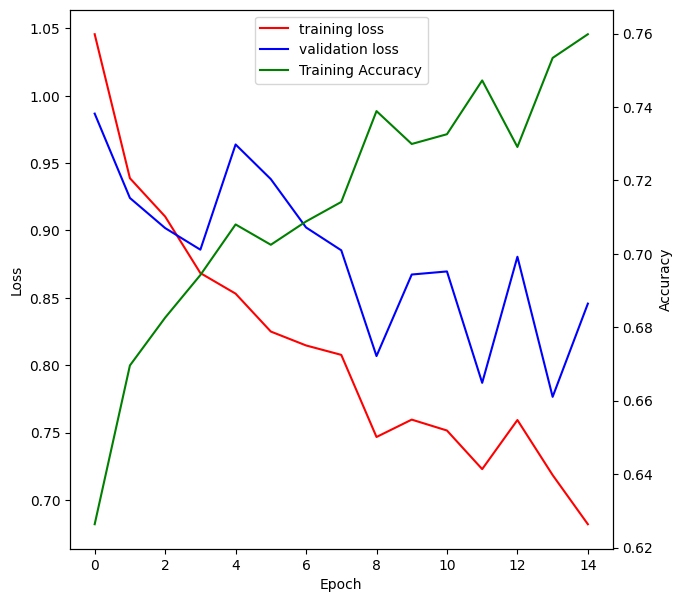

In [109]:
visualize_training_curve(model_1_results)

The chart illustrates the training process of a Recurrent Neural Network (RNN) model over 15 epochs. Overall this model shows higher variability.  The red line represents the training loss, which starts just below 1.05 and decreases with significant fluctuations, ending just above 0.80. The blue line shows the validation loss, which also starts just below 1.05 but exhibits more pronounced fluctuations, without a clear downward trend. The green line represents training accuracy, which increases from approximately 0.64 to around 0.76, despite some variability. The high variability and lack of consistent improvement in validation loss indicate potential overfitting or instability during training. This implies that the model may not be generalizing well to new data, and further optimization may be needed.

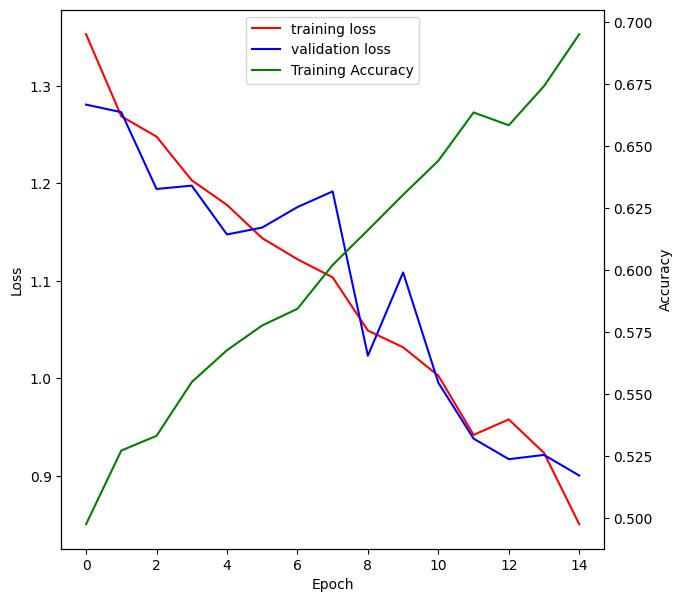

In [99]:
visualize_training_curve(model_2_results)

This last chart presents the training process of the CNN-LSTM model. It shows a similar trend to the previous one, however, there are some differences in the behavior of the loss and training curves:

The training loss decreases steadily from around 1.3 to approximately 0.9, indicating that the model is learning and reducing error over time, however, although the RNN model showed lower loss values, this model showed more consistency compared to the fluctuations the RNN model presented.  

The validation loss also decreases exhibiting some fluctuations, however, this variability is not as pronounced as the RNN model. This decrease in the loss shows a more clear downward trend compared to the RNN model, which doesn't show a clear trend.

And the training accuracy increases consistently from about 0.525 to 0.700, demonstrating the model’s improving ability to correctly classify training data.

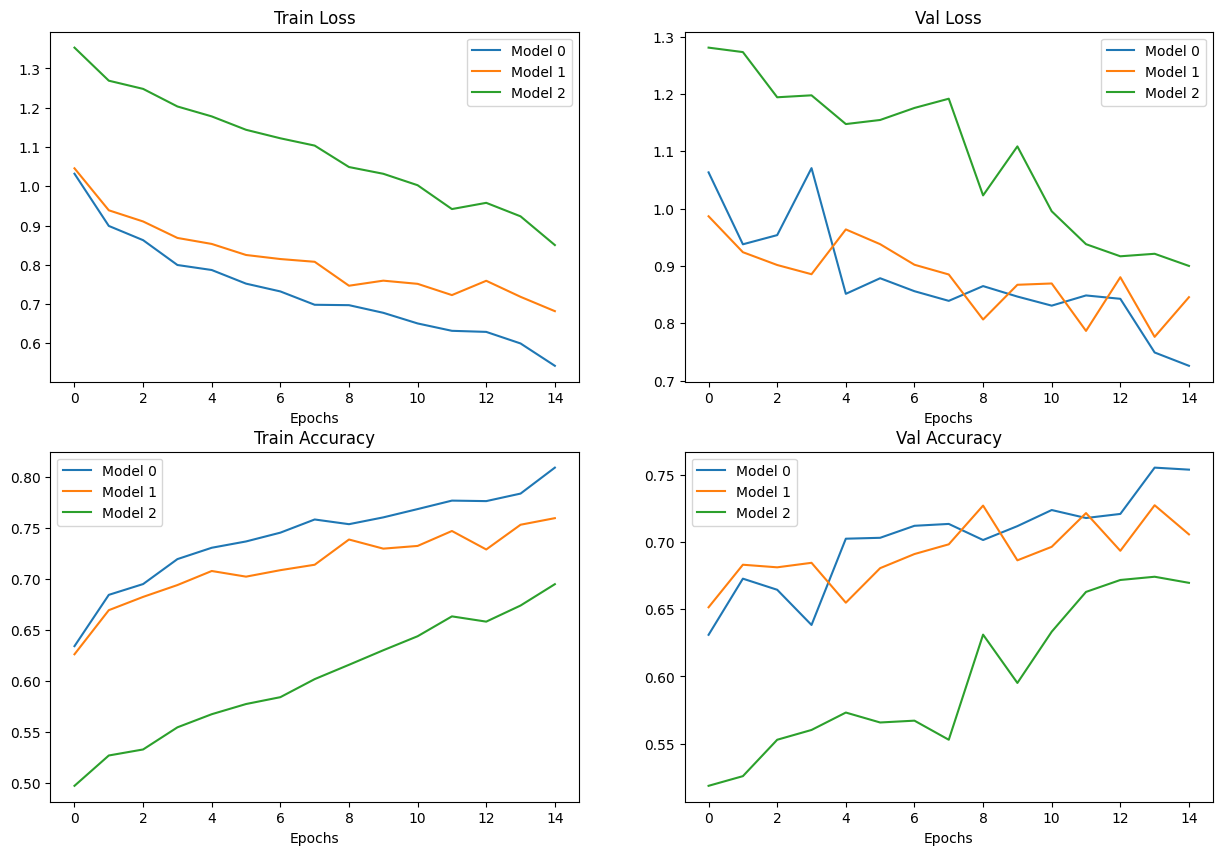

In [100]:
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_2_df = pd.DataFrame(model_2_results)

# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.plot(epochs, model_2_df["train_loss"], label="Model 2")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["val_loss"], label="Model 0")
plt.plot(epochs, model_1_df["val_loss"], label="Model 1")
plt.plot(epochs, model_2_df["val_loss"], label="Model 2")
plt.title("Val Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.plot(epochs, model_2_df["train_acc"], label="Model 2")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["val_acc"], label="Model 0")
plt.plot(epochs, model_1_df["val_acc"], label="Model 1")
plt.plot(epochs, model_2_df["val_acc"], label="Model 2")
plt.title("Val Accuracy")
plt.xlabel("Epochs")
plt.legend();

The charts above illustrate the difference of performance between the models. Clearly, CNN model (model_0) has the highest accuracy in the training and validation datasets. The RNN model shows a very similar performance in accuracy during training and similar variability in the validation accuracy compared to CNN model. And the CNN-LSTM model performed the worst compared to the other two models in training and validation accuracy.

The charts above also better illustrate the difference of performance between the models. In the "Train Loss" graph, all three models show a downward trend as epochs increase, indicating an improvement in loss on the training set over time. The CNN model (model_0) has the steepest decline followed by RNN model (model_1) and then CNN-LSTM (model_2).

The "Val Loss" graph shows fluctuations in loss on the validation set for all models as epochs increase. Unlike the training loss, these lines are not consistently decreasing which may indicate issues like overfitting or instability in learning.

In the "Train Accuracy" graph, there’s an upward trend for all models indicating improving accuracy on the training set as more epochs are completed. Here again, the CNN model shows rapid improvement initially and then stabilizes at a high accuracy level while the RNN and CNN-LSTM models improve more gradually.

Lastly, in the "Val Accuracy" chart, there are significant fluctuations for all models with no clear upward or downward trend. This suggests that none of the models are consistently improving their performance on unseen data (validation set).

Overall insights from these graphs suggest that while all models improve their performance on training data over time (both in terms of loss and accuracy), their performances on validation data do not show consistent improvement which could be indicative of overfitting or lack of generalization ability.

In [140]:
# Function to aggregate train_acc and val_acc
def aggregate(df):
    return {
        'train_acc_mean': df['train_acc'].mean(),
        'train_loss_mean': df['train_loss'].mean(),
        'val_acc_mean': df['val_acc'].mean(),
        'val_loss_std': df['val_loss'].mean()
    }

# Aggregate each dataframe
agg0 = aggregate(model_0_df)
agg1 = aggregate(model_1_df)
agg2 = aggregate(model_2_df)

# Combine results into a single dataframe
aggregated_df = pd.DataFrame([agg0, agg1, agg2])
aggregated_df.index = ['CNN model', 'RNN model', 'CNN-LSTM model']
aggregated_df.index.name = 'model_name'

aggregated_df

,train_acc_mean,train_loss_mean,val_acc_mean,val_loss_std
model_name,,,,
CNN model,0.742383,0.732744,0.701418,0.877407
RNN model,0.713144,0.813598,0.692113,0.881410
CNN-LSTM model,0.601689,1.091810,0.596937,1.094614


# Model Performance Comparison

## Test dataset performance

### CNN

In [101]:
loss_fn = nn.CrossEntropyLoss()

# Evaluate model 0 results
model_0_eval = evaluate_model(model=model_0, data_loader=test_dl,
    loss_fn=loss_fn, accuracy_fn=accuracy_function,
    device=device
)
model_0_eval

{'model_name': 'CNN_Model',
 'model_loss': 0.7674161791801453,
 'model_acc': 77.16475741239891}

### RNN

In [102]:
loss_fn = nn.CrossEntropyLoss()

# Evaluate model 1 results
model_1_eval = evaluate_model(model=model_1, data_loader=test_dl,
    loss_fn=loss_fn, accuracy_fn=accuracy_function,
    device=device
)
model_1_eval

{'model_name': 'CRNN_Model',
 'model_loss': 0.8732233643531799,
 'model_acc': 70.57572439353099}

### CNN-LSTM

In [103]:
loss_fn = nn.CrossEntropyLoss()

# Evaluate model 2 results

model_2_eval = evaluate_model(model=model_2, data_loader=test_dl,
    loss_fn=loss_fn, accuracy_fn=accuracy_function,
    device=device
)
model_2_eval

{'model_name': 'CNNLSTM',
 'model_loss': 0.8937350511550903,
 'model_acc': 67.33490566037736}

In [104]:
compare_results = pd.DataFrame([model_0_eval, model_1_eval, model_2_eval])
compare_results["training_time_secs"] = [2210.711, 1726.098, 1520.272]
compare_results

,model_name,model_loss,model_acc,training_time_secs
0,CNN_Model,0.767416,77.164757,2210.711
1,CRNN_Model,0.873223,70.575724,1726.098
2,CNNLSTM,0.893735,67.334906,1520.272


From the results above we can see that the CNN model performed the best in the test dataset and RNN with CNN-LSTM were somewhere close between each other. In terms of time the CNN model was the one that took the longest with 36 minutes approximately.

## Confusion Matrix

### CNN

Test set: Average loss: 0.0064, Accuracy: 654/874 (75%)



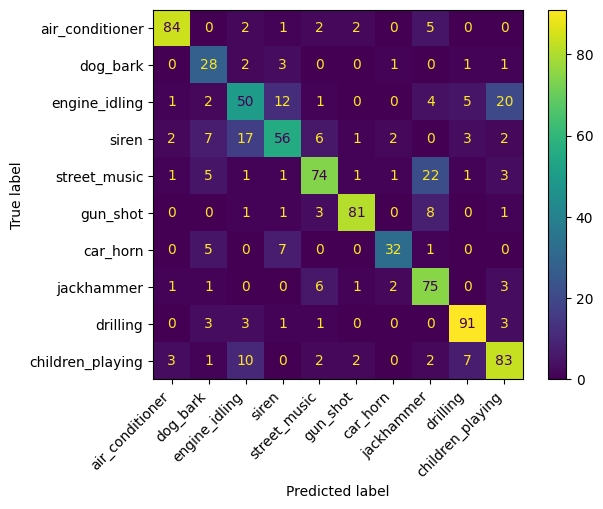

In [111]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Test and visualise the confusion matrix
criterion = nn.CrossEntropyLoss()
all_preds, all_targets, test_loss, accuracy = test(model_0, device, test_dl, criterion)

cm = confusion_matrix(all_targets, all_preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=train_ds.dataset.classes)
cmd.plot()
# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')
plt.show()

The confusion matrix for the CNN model evaluated against the test data reveals insights about the model's performance across the ten categories: air conditioner, dog bark, engine idling, siren, street music, gun shot, car horn, jackhammer, drilling and children playing. 

- **High Accuracy**: The model shows high accuracy in categories such as 'drilling' with 91 correct predictions and 'air conditioner' with 84 correct predictions. This suggests that the CNN model is good at identifying these two specific classes.

- **Misclassifications**: There are some small misclassifications, for example, 'engine idling' was often confused with 'children playing' (20 times) and 'siren' (12 times), or 'street music' was confused a 'jackhammer' (22 times).

- **Improvement Areas**: The model could be improved in distinguishing between categories like 'engine idling' and 'children playing', as well as 'street music' and 'jackhammer', or 'siren' and 'engine idling'. 

While overall performance appears proficient, there is an opportunity to refine it further by reducing misclassifications among certain sound categories.

### RNN

Test set: Average loss: 0.0068, Accuracy: 618/874 (71%)



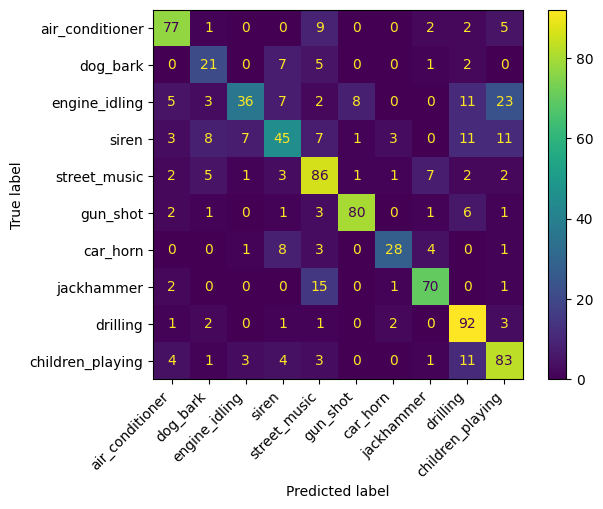

In [112]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Test and visualise the confusion matrix
criterion = nn.CrossEntropyLoss()
all_preds, all_targets, test_loss, accuracy = test(model_1, device, test_dl, criterion)

cm = confusion_matrix(all_targets, all_preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=train_ds.dataset.classes)
cmd.plot()
# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')
plt.show()

- **Air conditioner**: RNN correctly identified 77 air conditioner sounds, compared to CNN's 84. However, RNN had fewer misclassifications with street music.
- **Dog bark**: RNN correctly identified 21 forests, lower than CNN's results, how it had more missclassifications with siren and street music.
- **Engine idling**: RNN identified 36 correct engine sounds, lower than CNN, but with the same level of missclassifications. This seems to be a hard class to identify for both models.
- **Siren**: RNN correctly classified 45 siren sounds, lower than CNN, but with fewer errors in general with the other classes.
- **Street music**: RNN correctly classified 86 sounds, higher than CNN, but with higher misclassifications than CNN.
- **Gun shot**: RNN correctly identified 80 gun shots sounds, similar to CNN, indicating similar performance in this category.
- **Car horn**: RNN correctly identified 28 gun shots sounds, very close to CNN but lower.
- **Jackhammer**: RNN correctly identified 70 jackhammer sounds, similar to CNN but lower, and with higher missclassifications as well.
- **Drilling**: RNN showed a strong performance with 92 correct drilling sounds, one higher than CNN, and with lower misclassifications than CNN.
- **Children playing**: RNN correctly identified 83 children playing shots sounds, exactly the same as to CNN, but with a better missclassification rate comapred to CNN.

Overall, both models have good accuracy, with the CNN model showing higher precision across most categories. However, the RNN model shows promise in reducing specific misclassifications.

### CNN-LSTM

Test set: Average loss: 0.0072, Accuracy: 604/874 (69%)



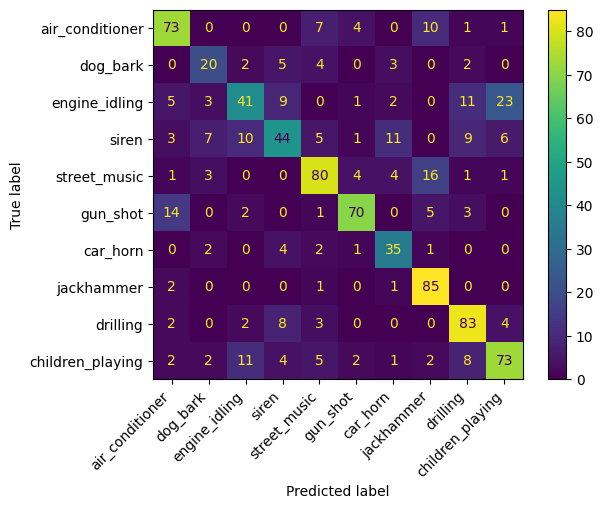

In [113]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Test and visualise the confusion matrix
criterion = nn.CrossEntropyLoss()
all_preds, all_targets, test_loss, accuracy = test(model_2, device, test_dl, criterion)

cm = confusion_matrix(all_targets, all_preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=train_ds.dataset.classes)
cmd.plot()
# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')
plt.show()

- **Air conditioner**: CNN-LSTM correctly identified 73 air conditioner sounds, lower than CNN's 84. However, RNN had also fewer misclassifications with street music.
- **Dog bark**: CNN-LSTM correctly identified 20 dog barks, lower than CNN's results, and it had more missclassifications with siren and street music.
- **Engine idling**: CNN-LSTM identified 41 correct engine sounds, lower than CNN, and with the higher levels of missclassifications. This seems to be a hard class to identify for both models as well.
- **Siren**: CNN-LSTM correctly classified 44 siren sounds, lower than CNN, and with higher errors in general with the other classes. This seems to be a hard class for this model.
- **Street music**: CNN-LSTM correctly classified 80 sounds, higher than CNN, and with lower misclassifications than CNN.
- **Gun shot**: CNN-LSTM correctly identified 70 gun shot sounds, lower than CNN, and with higher missclassifications than CNN as well.
- **Car horn**: CNN-LSTM correctly identified 35 car horn sounds, very close to CNN and the lowest classification category.
- **Jackhammer**: CNN-LSTM correctly identified 85 jackhammer sounds, higher than CNN and with lower missclassifications as well.
- **Drilling**: CNN-LSTM showed a strong performance with 83 correct drilling sounds, lower than CNN, and with higher misclassifications than CNN.
- **Children playing**: CNN-LSTM correctly identified 73 children playing sounds, lower than CNN, and with higher missclassification rate compared to CNN.

Overall, this model is the one with the lowest accuracy, however, the CNN-LSTM model shows promise in reducing specific misclassifications like 'jackhammer'.